In [ ]:
import subprocess
 
CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)
 
if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

CUDA version: 10.1


In [ ]:
!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

import torch

print("Torch version:", torch.__version__)

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4MB 25kB/s 
     |████████████████████████████████| 12.8MB 52.1MB/s 
     |████████████████████████████████| 71kB 4.1MB/s 
  Created wheel for ftfy: filename=ftfy-5.9-cp36-none-any.whl size=46451 sha256=82b96244fd12105f8e848f918e8ea77cefc77c6050bff71590c8034154b88ee1
  Stored in directory: /root/.cache/pip/wheels/5e/2e/f0/b07196e8c929114998f0316894a61c752b63bfa3fdd50d2fc3
Successfully built ftfy
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
Torch version: 1.7.1+cu101


In [ ]:
!git clone https://github.com/openai/CLIP.git
%cd CLIP

Cloning into 'CLIP'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 58 (delta 11), reused 28 (delta 8), pack-reused 24
Unpacking objects: 100% (58/58), done.
/content/CLIP


In [ ]:
import clip

In [ ]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

model, transform = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 354M/354M [00:25<00:00, 13.7MiB/s]


In [ ]:
!pip install fastbook
import fastbook

     |████████████████████████████████| 727kB 9.9MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 194kB 13.0MB/s 
     |████████████████████████████████| 1.2MB 18.9MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
fastbook.setup_book()

Mounted at /content/gdrive


In [ ]:
from fastai.vision.all import *

In [ ]:
path=Path("/content/gdrive/MyDrive/Dataset2")

In [ ]:

files = get_image_files(path)
files[0]

Path('/content/gdrive/MyDrive/Dataset2/Images/potatoes1.jpg')

In [ ]:
files[0].stem

'potatoes1'

In [ ]:
def label_func(x):
      s=str(x.stem)
      result = ''.join([i for i in s if not i.isdigit()])
      return result;

label_func(files[0])

'potatoes'

In [ ]:
labels = list(set(files.map(label_func)))
len(labels)

8

In [ ]:
lbl2files = {l: [f for f in files if label_func(f) == l] for l in labels}

In [ ]:
def open_image(fname, size=224):
    img = PILImage.create(fname)
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0

In [ ]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.splbl2files = [{l: [f for f in files[splits[i]] if label_func(f) == l] for l in labels}
                          for i in range(2)]
        self.valid = {f: self._draw(f,1) for f in files[splits[1]]}
    def encodes(self, f):
        f2,same = self.valid.get(f, self._draw(f,0))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, same)
    
    def _draw(self, f, split=0):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls)) 
        return random.choice(self.splbl2files[split][cls]),same

In [ ]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        if len(self) > 2:
            img1,img2,similarity = self
        else:
            img1,img2 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=similarity, ctx=ctx, **kwargs)

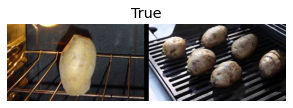

In [ ]:
img = PILImage.create(files[0])
img1 = PILImage.create(files[1])
s = SiameseImage(img, img1, True)
s.show();

In [ ]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)

In [ ]:
valids = [v[0] for k,v in tfm.valid.items()]      
assert not [v for v in valids if v in files[splits[0]]]

In [ ]:
tls = TfmdLists(files, tfm, splits=splits)

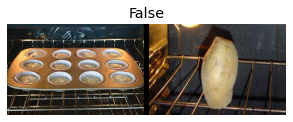

In [ ]:
show_at(tls.valid, 0)

In [ ]:
dls = tls.dataloaders(bs=4,after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls._types

{__main__.SiameseImage: [fastai.torch_core.TensorImage,
  fastai.torch_core.TensorImage,
  torch.Tensor]}

In [ ]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

In [ ]:
print(f'Shape of one batch: {dls.one_batch()[0].shape}')

Shape of one batch: torch.Size([4, 3, 224, 224])


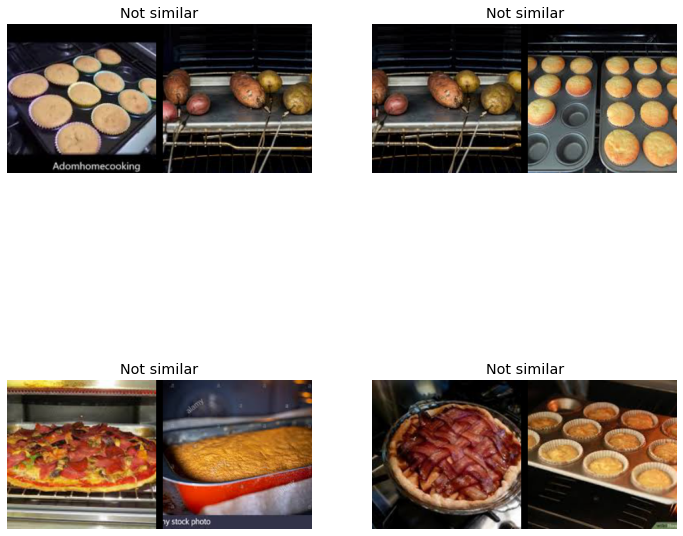

In [ ]:
dls.show_batch()

In [ ]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)


class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)        

In [ ]:
class nxt(Module):
    def __init__(self):
       self.f1=nn.Linear(512,1024) 
    
    def forward(self, x1):
        x1=model.encode_image(x1).float()
        x1=self.f1(x1)
        return x1

In [ ]:
encoder=nxt()
head = create_head(512*2, 2, ps=0.5)
net = SiameseModel(encoder, head[1:])

In [ ]:
net=net.cuda()

In [ ]:
net

SiameseModel(
  (encoder): nxt(
    (f1): Linear(in_features=512, out_features=1024, bias=True)
  )
  (head): Sequential(
    (1): Flatten(full=False)
    (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=2048, out_features=512, bias=False)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=512, out_features=2, bias=False)
  )
)

In [ ]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [ ]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [ ]:

learn = Learner(dls, net, loss_func=loss_func, splitter=siamese_splitter, metrics=accuracy)

In [ ]:
learn.fine_tune(50)

epoch,train_loss,valid_loss,accuracy,time
0,0.788666,1.029625,0.583333,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.867394,0.772464,0.645833,00:05
1,0.839473,0.705148,0.645833,00:05
2,0.766297,0.658232,0.666667,00:05
3,0.764572,0.634934,0.645833,00:05
4,0.731437,0.646699,0.645833,00:05
5,0.677092,0.692182,0.625000,00:05
6,0.711489,0.591146,0.708333,00:05
7,0.700623,0.597712,0.666667,00:05
8,0.689438,0.541061,0.666667,00:05
9,0.745720,0.578562,0.687500,00:05


In [ ]:
@typedispatch
def show_results(x:SiameseImage, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = f'Actual: {["Not similar","Similar"][x[2][i].item()]} \n Prediction: {["Not similar","Similar"][torch.argmax(nn.Softmax(dim=0)(y[2][i]))]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

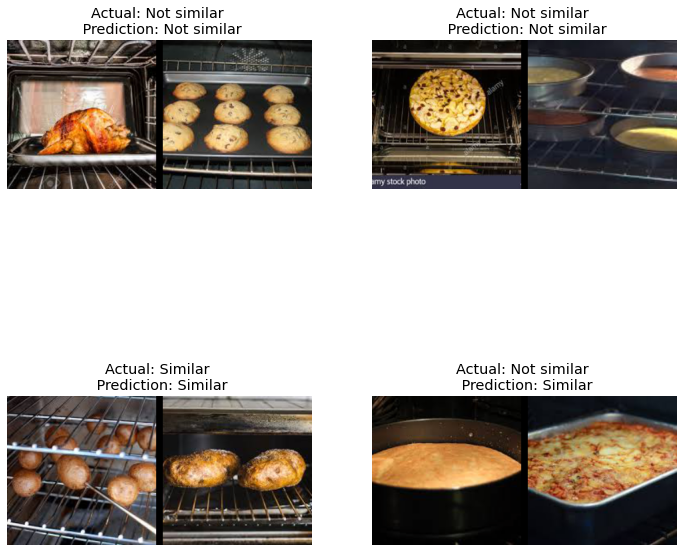

In [ ]:
learn.show_results()

In [ ]:
x=nn.Softmax(dim=0)
def predict(self, item, rm_type_tfms=None, with_input=False):
        dl = self.dls.test_dl([item], rm_type_tfms=rm_type_tfms, num_workers=0)
        inp,preds,_,dec_preds = self.get_preds(dl=dl, with_input=True, with_decoded=True)
        i = getattr(self.dls, 'n_inp', -1)
        inp = (inp,) if i==1 else tuplify(inp)
        dec = self.dls.decode_batch(inp + tuplify(dec_preds))[0]
        dec_inp,dec_targ = map(detuplify, [dec[:i],dec[i:]])
        res = dec_targ,dec_preds[0],preds[0]
        if with_input: res = (dec_inp,) + res
        return res

In [ ]:
@patch
def siampredict(self:Learner, item, rm_type_tfms=None, with_input=False):
    res = self.predict(item, rm_type_tfms=None, with_input=False)
    
    z=x(res[0])
    
    if torch.argmax(z) == tensor(0):
        SiameseImage(item[0], item[1], 'Prediction: Not similar').show()
    else:
        SiameseImage(item[0], item[1], 'Prediction: Similar').show()
    return res

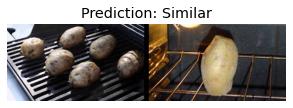

In [ ]:
imgtest = PILImage.create(files[0])
imgval = PILImage.create(files[1])
siamtest = SiameseImage(imgval, imgtest)
res=learn.siampredict(siamtest)

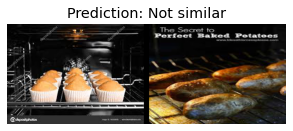

In [ ]:
imgtest = PILImage.create(files[2])
imgval = PILImage.create(files[100])
siamtest = SiameseImage(imgval, imgtest)
res=learn.siampredict(siamtest)